# User to Item Recommendation system

In [3]:
import pandas as pd
import numpy as np
from keras.models import load_model

links = pd.read_csv('gdrive/My Drive/links.csv')
movies = pd.read_csv('gdrive/My Drive/movies.csv')
ratings = pd.read_csv('gdrive/My Drive/ratings.csv')
tags = pd.read_csv('gdrive/My Drive/tags.csv')

Using TensorFlow backend.


Cleaning genres string. Replacing "|" with " " and replacing null with blank string.

In [0]:
tags_1 = pd.DataFrame(tags.groupby('movieId')['tag'].apply(lambda x: "%s" % ' '.join(x)))
df = pd.merge(movies, tags_1,on='movieId', how='left')
df['genres'] = df['genres'].str.replace('|',' ')
df.fillna("",inplace=True)

Label Encoding "movieId" column so that the movieId's start with 1 and end with 9742 (max number of movies in the dataset).

In [0]:
from sklearn.preprocessing import LabelEncoder
item_enc = LabelEncoder()

df['movieId'] = item_enc.fit_transform(df['movieId'].values)

df['movieId'] = df['movieId']+1

Converting upper case characters to lower case. To avoid duplicates when the words are tokenized.

In [0]:
import string

df.genres = df.genres.apply(lambda x: x.lower())
df.genres = df.genres.apply(lambda x: x.translate(string.punctuation))

In [0]:
ratings['movieId'] = item_enc.fit_transform(ratings['movieId'].values)

ratings['movieId'] = ratings['movieId']+1


We will be grouping both movies and their timestamps by userID. Since movies are arranged in ascending order, we will have to reorder movies PER user according to their timestamp, which will result in a better sequence order. 

In [0]:
user_movies_watched = pd.DataFrame(ratings.groupby(['userId']).apply(lambda x: [list(x['movieId'])]).apply(pd.Series))
all_timestamps = pd.DataFrame(ratings.groupby(['userId']).apply(lambda x: [list(x['timestamp'])]).apply(pd.Series))
user_movies_watched = pd.concat([user_movies_watched,all_timestamps], axis=1)

user_movies_watched.columns = ['movies','timestamps']

Grouping movies by Genres.

In [0]:
genre_classes = pd.DataFrame(df.groupby(['genres']).apply(lambda x: [list(x['movieId'])]).apply(pd.Series)).reset_index()
genre_classes.columns = ['genres','movieId']

Adding a new column which will now represent the unique genre strings.



In [14]:
genre_classes_column = [int(i) for i in range(1,952)]
genre_classes['genres_class'] = np.array(genre_classes_column)
genre_classes

,genres,movieId,genres_class
0,(no genres listed),"[8518, 8685, 8688, 8783, 8837, 8903, 9034, 905...",1
1,action,"[9, 64, 173, 216, 556, 877, 1144, 1202, 1648, ...",2
2,action adventure,"[575, 607, 637, 802, 901, 991, 1209, 1368, 161...",3
3,action adventure animation,"[6926, 7923, 7924, 7925, 7926, 7942, 7943, 795...",4
4,action adventure animation children,"[7902, 7903, 7905, 7907, 8345, 9709]",5
...,...,...,...
946,sci-fi thriller,"[669, 1321, 2599, 2935, 3618, 3671, 3943, 5361...",947
947,sci-fi thriller imax,[7688],948
948,thriller,"[113, 162, 207, 332, 367, 399, 428, 474, 553, ...",949
949,war,"[2006, 2007, 4388, 6787]",950


Adding a new column to the main dataframe, which will now hold the tokenized genres.



In [0]:
genre_classes_column = [int(i) for i in range(1,952)]
genre_classes['genres_class'] = np.array(genre_classes_column)

genre_dict = pd.Series(genre_classes.genres_class.values,index=genre_classes.genres).to_dict()
df_gen = df.genres.values
df_gen=[genre_dict[i] for i in df_gen]
df['genres_class'] = np.array(df_gen)

A dictionary of movies and its unique genre_class. 

In [0]:
genre_movie_dict = pd.Series(df.genres_class.values,index=df.movieId).to_dict()

In [17]:
df.head(3)

,movieId,title,genres,tag,genres_class
0,1,Toy Story (1995),adventure animation children comedy fantasy,pixar pixar fun,352
1,2,Jumanji (1995),adventure children fantasy,fantasy magic board game robin williams game,418
2,3,Grumpier Old Men (1995),comedy romance,moldy old,733


In [19]:
user_movies_watched.head(3)

,movies,timestamps
userId,,
1,"[1, 3, 6, 44, 47, 63, 90, 98, 125, 131, 137, 1...","[964982703, 964981247, 964982224, 964983815, 9..."
2,"[278, 292, 1284, 2671, 4608, 5295, 6237, 6299,...","[1445714835, 1445715029, 1445715228, 144571488..."
3,"[31, 462, 546, 566, 586, 657, 697, 832, 853, 9...","[1306463578, 1306464275, 1306463619, 130646422..."


Obtaining a single long list which has all the movies seen by every user. Also obtaining a single long list which has all the associated timestamps.

In [0]:
movies_all = user_movies_watched.movies.values
time_stamps_all = user_movies_watched.timestamps.values

For every user(indicated by the sublist **i**, we will be sorting/rearranging movies according to their timestamps.

In [0]:

movies_list = []
for i in range(0,len(movies_all)):
    movies_list.append([x for _,x in sorted(zip(time_stamps_all[i],movies_all[i]))])


Flattening the list of lists into one long list. Later we will create a sequence of 18 or 36.

In [0]:
movies_all = [item for sublist in movies_list for item in sublist]
genres_all = [genre_movie_dict[item] for item in movies_all]

Will be creating a sequence of 18 movies (which will be our movie Input). Next_movie list will have the movie which immediately follows after a particular sequence.

In [0]:
maxlen = 18 
step = 18
movies_list = []
genres_list = []

for i in range(0, len(movies_all), step):
    movies_list.append(movies_all[i: i + maxlen])
    genres_list.append(genres_all[i: i + maxlen])
    

In [26]:
len(movies_list)

5602

In [27]:
gen_size = max(genres_all)
movies_size = max(movies_all)

print(gen_size,movies_size)

951 9724


Scaling movies array.

In [0]:
x_mov = np.asarray(movies_list).astype('float32')/9724
x_gen = np.asarray(genres_list)

Since there are 5602 different sequences of length 18, we will be creating a multi class **y** wherein every 1 indicates the corresponding sequence. Say a new user watches movies, the users watch pattern must match one of those sequences. 

In [ ]:
y = [i for i in range(5602)]
y = pd.get_dummies(y)
y

In [0]:
# y = np.zeros((5602, 9743))
# def y_s(j,row):
#     for i in row:
#         y[j,i]=1

# for i in range(0,5602):
#     y_s(i,movies_list[i])

In [34]:
y.shape

(5602, 5602)

The model. Genres will be embedded. The output of embedding will be concatenated with movie input which are then fed to a LSTM layer. 

In [0]:
import keras
from keras.layers import Concatenate, Dense, Dropout, Flatten, LSTM
from keras.models import Model
from keras.layers import Input, Reshape, Dot
from keras.layers.embeddings import Embedding
from keras.optimizers import Adam
from keras.regularizers import l2
from keras.layers import Add, Activation, Lambda
from keras.layers import Bidirectional

def recommend():
  
    genres = Input(shape=(18,))
    g = Embedding(gen_size+1, 50)(genres)
    g = Flatten()(g)

    movies = Input(shape=(18,))
    
    x = Concatenate()([movies, g])
    x = Reshape((1,918))(x)
    x = LSTM(100) (x)
    x = Activation('relu')(x)
    x = Dense(5602)(x)
    x = Activation('softmax')(x)
    
    model = Model(inputs=[movies, genres], outputs=x)
    opt = keras.optimizers.Adam(lr=0.001)
    model.compile(loss='categorical_crossentropy', optimizer=opt,metrics=['accuracy'])
    return model


Summary of the model.

In [236]:
model = recommend()
model.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           (None, 18)           0                                            
__________________________________________________________________________________________________
embedding_8 (Embedding)         (None, 18, 50)       47600       input_11[0][0]                   
__________________________________________________________________________________________________
input_12 (InputLayer)           (None, 18)           0                                            
__________________________________________________________________________________________________
flatten_8 (Flatten)             (None, 900)          0           embedding_8[0][0]                
____________________________________________________________________________________________

Training the model.

In [237]:
history = model.fit(x=[x_mov,x_gen], y=y, batch_size=16, epochs=25, verbose=1)

Epoch 1/25
5602/5602 [==============================] - 4s 627us/step - loss: 8.6921 - acc: 0.0000e+00
Epoch 2/25
5602/5602 [==============================] - 2s 416us/step - loss: 8.6193 - acc: 0.0012
Epoch 3/25
5602/5602 [==============================] - 2s 432us/step - loss: 7.5266 - acc: 0.0707
Epoch 4/25
5602/5602 [==============================] - 2s 430us/step - loss: 4.0750 - acc: 0.4945
Epoch 5/25
5602/5602 [==============================] - 2s 432us/step - loss: 1.4821 - acc: 0.8358
Epoch 6/25
5602/5602 [==============================] - 2s 416us/step - loss: 0.5654 - acc: 0.9561
Epoch 7/25
5602/5602 [==============================] - 2s 422us/step - loss: 0.2421 - acc: 0.9900
Epoch 8/25
5602/5602 [==============================] - 2s 425us/step - loss: 0.1159 - acc: 0.9984
Epoch 9/25
5602/5602 [==============================] - 2s 424us/step - loss: 0.0626 - acc: 0.9995
Epoch 10/25
5602/5602 [==============================] - 2s 427us/step - loss: 0.0377 - acc: 1.0000
Epoch

Plots of loss vs. epoch and accuracy vs. epoch.

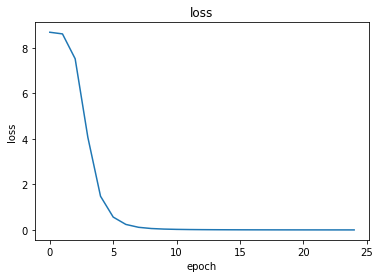

In [238]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.title('loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

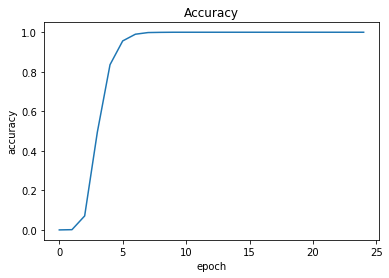

In [239]:
import matplotlib.pyplot as plt
plt.plot(history.history['acc'])
plt.title('Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.show()

random inputs to the model.

In [0]:
a = [225, 970,1487,1488, 258, 8064, 8377, 7373,7769,3563, 6332]
g = [genre_movie_dict[i] for i in a]
N = 18 - len(a)
mov_i = np.pad(a, (0, N), 'constant')
mov_i = np.asarray(mov_i)/9724

gen_i = np.pad(a, (0, N), 'constant')
gen_i = np.asarray(gen_i)

The pattern matches sequences 3226, 3221, 667 (the top 3)

In [206]:
preds = model.predict([np.array([mov_i,]),np.array([gen_i,])])
sequence = preds[0].argsort()[-3:][::-1]
sequence

array([3226, 3221,  667])

In [0]:
abc = [df.movieId[df.movieId.isin(movies_list[i])].values.tolist() for i in b]
abc1 = [item for sublist in abc for item in sublist]